In [209]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

import system.from_higher_basis_truncation_tunable_full_cosine as system
importlib.reload(system)
import utils.floquet_solver as fsolver
importlib.reload(fsolver)
import utils.solver as solver
importlib.reload(solver)
import pulse.tanh as tanh
importlib.reload(tanh)
import utils.expectation_values as expect
importlib.reload(expect)
pass

# Designing Floquet Solver

In [210]:
t_max = 146.17831127951132
offset = 0.10188603062894215
freq = system.first_energy_spacing/3 - offset
peaks_tlist = np.arange(0, t_max, (2*np.pi)/(freq))
tlist = np.linspace(0, t_max, int(t_max*100))

amp = 7.034040495797981
tanh.setup(amp, freq, 0.5, 3, tlist)
ramp_time = 0
for t in tlist:
    if tanh.pulse_func(t) > amp-0.01:
        ramp_time = t
        break
print(ramp_time)
solution = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state, pbar=True)

13.00162867154931
10.0%. Run time:   0.81s. Est. time left: 00:00:00:07
20.0%. Run time:   1.57s. Est. time left: 00:00:00:06
30.0%. Run time:   2.42s. Est. time left: 00:00:00:05
40.0%. Run time:   3.31s. Est. time left: 00:00:00:04
50.0%. Run time:   3.99s. Est. time left: 00:00:00:03
60.0%. Run time:   4.64s. Est. time left: 00:00:00:03
70.0%. Run time:   5.24s. Est. time left: 00:00:00:02
80.0%. Run time:   5.95s. Est. time left: 00:00:00:01
90.0%. Run time:   6.61s. Est. time left: 00:00:00:00
Total run time:   7.35s


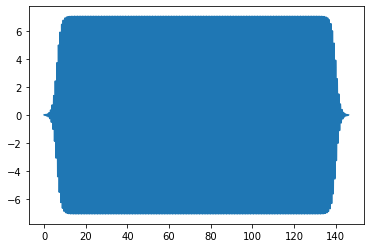

In [211]:
plt.plot(tlist, tanh.get_pulse(tlist))

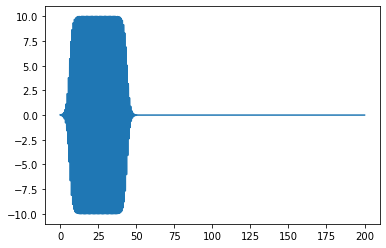

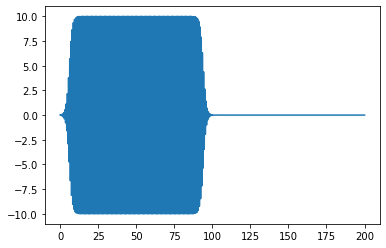

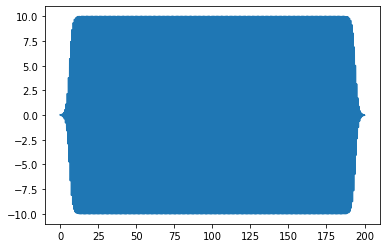

In [212]:
def htangent_pulse(t, args=None):
    global _k, _b, _width, _wd
    return 10 * np.cos(_wd*t) * (( np.tanh(_k*t-_b) - np.tanh(_k*(t-_width)+_b) ) / 2 )

_k = 0.5
_width = 50
_b = 3
_wd = 8
test_tlist = np.linspace(0, 200, 10000)
plt.plot(test_tlist, np.vectorize(htangent_pulse)(test_tlist))
plt.show()
_k = 0.5
_width = 100
_b = 3
test_tlist = np.linspace(0, 200, 10000)
plt.plot(test_tlist, np.vectorize(htangent_pulse)(test_tlist))
plt.show()
_k = 0.5
_width = 200
_b = 3
test_tlist = np.linspace(0, 200, 10000)
plt.plot(test_tlist, np.vectorize(htangent_pulse)(test_tlist))
plt.show()

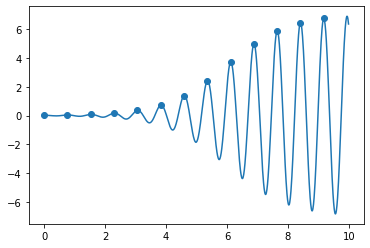

In [213]:
# Create list of points at peaks of pulse

num_of_points = 1000
num_of_durPoints = 13

plt.plot(tlist[:num_of_points], tanh.get_pulse(tlist)[:num_of_points])
plt.scatter(peaks_tlist[:num_of_durPoints], tanh.get_pulse(peaks_tlist)[:num_of_durPoints])


0.6777283624242615


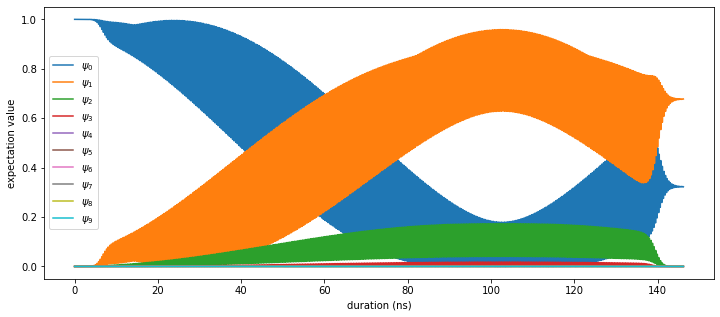

In [214]:
expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlabel("duration (ns)")
ax.set_ylabel("expectation value")
for i in range(0, len(expectation_values)):
    ax.plot(solution.times, expectation_values[i], label="$\psi_{%i}$" % i)
plt.legend()
print(expectation_values[1][-1])

## Main algo

In [215]:
pertubation_ramp_up_time = ramp_time + 10
pertubation_ramp_down_time = ramp_time + 10
pertubation_period = 1/freq

ramp_up_tlist = []
ramp_down_tlist = []
for t in tlist:
    if t < pertubation_ramp_up_time:
        ramp_up_tlist.append(t)
    if t > tlist[-1] - pertubation_ramp_down_time:
        ramp_down_tlist.append(t)

for t in peaks_tlist:
    if t > ramp_up_tlist[-1]:
        ramp_up_tlist.append(t)
        break
# ramp_up_tlist = np.linspace(ramp_up_tlist[0], ramp_up_tlist[-1], len(ramp_up_tlist)*2)

for i in range(len(peaks_tlist)):
    if peaks_tlist[i] > ramp_down_tlist[0]:
        ramp_down_tlist.insert(0, peaks_tlist[i-1])
        break
# ramp_down_tlist = np.linspace(ramp_down_tlist[0], ramp_down_tlist[-1], len(ramp_down_tlist)*2)

ramp_up_pulse = []
def ramp_up_pulse_func(t, args):
    answer = tanh.pulse_func(t)
    ramp_up_pulse.append(answer)
    return answer

ramped_up_solution = solver.time_evolve(system.H0, system.H1, ramp_up_pulse_func, ramp_up_tlist, system.starting_state, {}, True, True)
    

def pertubation_steady_state(t, args):
    return tanh.pulse_func(t+ramp_up_tlist[-1])
steady_state_hamiltonian = [system.H0, [system.H1, pertubation_steady_state]]
f_modes_0, f_energies = floquet_modes(steady_state_hamiltonian, pertubation_period, {})
f_coeff = floquet_state_decomposition(f_modes_0, f_energies, ramped_up_solution.final_state) # initial state in terms of floquet modes

f_modes_t = floquet_modes_t(f_modes_0, f_energies, ramp_down_tlist[0], steady_state_hamiltonian, pertubation_period, {})

psi_at_end_of_steady_state = floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, ramp_down_tlist[0], steady_state_hamiltonian, pertubation_period, {})

ramp_down_pulse = []
def ramp_down_pulse_func(t, args):
    answer = tanh.pulse_func(t)
    ramp_down_pulse.append(answer)
    return answer
ramped_down_solution = solver.time_evolve(system.H0, system.H1, ramp_down_pulse_func, ramp_down_tlist, psi_at_end_of_steady_state, {}, True, True)

fidelity = expect.expectation_value(ramped_down_solution.final_state, system.target_state)
print(fidelity)

10.0%. Run time:   0.11s. Est. time left: 00:00:00:00
20.0%. Run time:   0.22s. Est. time left: 00:00:00:00
30.0%. Run time:   0.32s. Est. time left: 00:00:00:00
40.0%. Run time:   0.43s. Est. time left: 00:00:00:00
50.0%. Run time:   0.54s. Est. time left: 00:00:00:00
60.0%. Run time:   0.65s. Est. time left: 00:00:00:00
70.0%. Run time:   0.75s. Est. time left: 00:00:00:00
80.0%. Run time:   0.86s. Est. time left: 00:00:00:00
90.0%. Run time:   0.97s. Est. time left: 00:00:00:00
Total run time:   1.24s
10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.29s. Est. time left: 00:00:00:01
30.0%. Run time:   0.43s. Est. time left: 00:00:00:00
40.0%. Run time:   0.54s. Est. time left: 00:00:00:00
50.0%. Run time:   0.65s. Est. time left: 00:00:00:00
60.0%. Run time:   0.75s. Est. time left: 00:00:00:00
70.0%. Run time:   0.86s. Est. time left: 00:00:00:00
80.0%. Run time:   0.98s. Est. time left: 00:00:00:00
90.0%. Run time:   1.11s. Est. time left: 00:00:00:00
Tota

In [219]:
print(expect.expectation_value(solution.final_state, system.target_state))


0.677728362424262


## Test to see if floquet state is the same as the regular integration state at time t

In [223]:
time_at_end_of_floquet_solving = ramp_down_tlist[0]
time_index_in_tlist_at_end_of_floquet_solving = -1
for i in range(len(tlist)):
    if t >= time_at_end_of_floquet_solving:
        time_index_in_tlist_at_end_of_floquet_solving = i
        break
solution.states[time_index_in_tlist_at_end_of_floquet_solving]

Quantum object: dims = [[10], [1]], shape = (10, 1), type = ket
Qobj data =
[[ 7.80349374e-02-5.62163601e-01j]
 [-6.62985502e-02+8.19470691e-01j]
 [ 7.49654379e-03-9.35431017e-03j]
 [-3.28340630e-03+4.05329775e-02j]
 [ 1.05704771e-03-3.05010326e-03j]
 [-9.65448752e-04+1.19261018e-02j]
 [ 2.36125020e-04-2.91271947e-04j]
 [-1.51365707e-04+1.86735411e-03j]
 [ 5.27264987e-05-8.25507853e-05j]
 [-4.23126926e-05+5.21943499e-04j]]

In [220]:
psi_at_end_of_steady_state

Quantum object: dims = [[10], [1]], shape = (10, 1), type = ket
Qobj data =
[[ 7.80454039e-01-3.74936977e-01j]
 [-3.25443019e-01+3.48277157e-01j]
 [ 1.10629461e-01-9.06987260e-02j]
 [-3.59406479e-02+2.84404900e-02j]
 [ 1.67972014e-02-1.06161365e-02j]
 [-8.26858139e-03+6.57755839e-03j]
 [ 4.10884056e-03-2.64173498e-03j]
 [-1.96565399e-03+1.36736594e-03j]
 [ 1.03041767e-03-5.91872650e-04j]
 [-5.20472324e-04+3.61000748e-04j]]

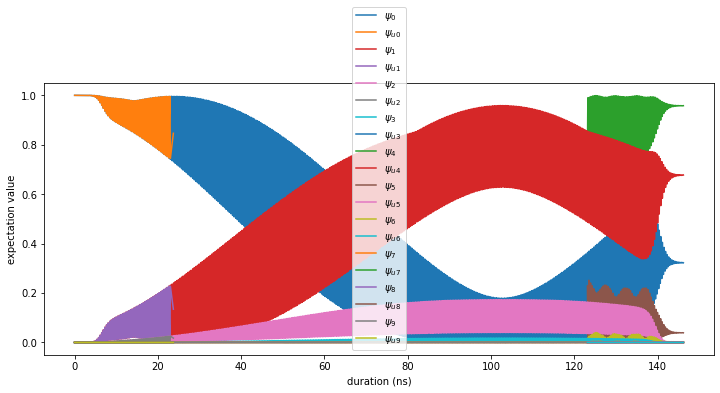

In [217]:
expectation_values_ramp_up = expect.get_all_expectation_values(ramped_up_solution.states, system.basis_states)
expectation_values_ramp_down = expect.get_all_expectation_values(ramped_down_solution.states, system.basis_states)
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlabel("duration (ns)")
ax.set_ylabel("expectation value")
for i in range(0, len(expectation_values)):
    ax.plot(tlist, expectation_values[i], label="$\psi_{%i}$" % i)
    ax.plot(ramp_up_tlist, expectation_values_ramp_up[i], label="$\psi_{u %i}$" % i)
    ax.plot(ramp_down_tlist, expectation_values_ramp_down[i])
plt.legend()

132138 0.01739253141461679 7.034038764057034
130185 123.13466279183143 146.17831127951132


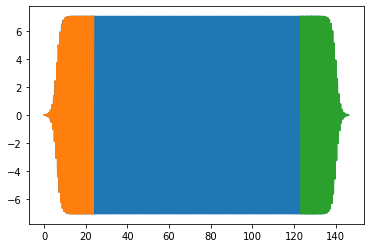

In [218]:
ramp_up_pulse_tlist = np.linspace(ramp_up_tlist[0], ramp_up_tlist[-1], len(ramp_up_pulse))
print(len(ramp_up_pulse), ramp_up_pulse[0], ramp_up_pulse[-1])
print(len(ramp_down_pulse), ramp_down_tlist[0], ramp_down_tlist[-1])
ramp_down_pulse_tlist = np.linspace(ramp_down_tlist[0], ramp_down_tlist[-1], len(ramp_down_pulse))

plt.plot(tlist, tanh.get_pulse(tlist))
plt.plot(ramp_up_pulse_tlist, ramp_up_pulse)
plt.plot(ramp_down_pulse_tlist, ramp_down_pulse)
plt.show()